In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:

from IPython.display import display, Markdown

import sys
sys.path.append('.')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from util import (
  draw_graphs as _draw_graphs
)
from pipeline import make_pipeline

from mcopt import ot, MorseGraph

In [3]:
pipeline = make_pipeline()

bi_complex = pipeline.dataset('binary_gaussian_complex')
tri_complex = pipeline.dataset('trinary_gaussian_complex')

display(Markdown(bi_complex.display_description()))
display(Markdown(tri_complex.display_description()))


# Binary Gaussian Complex


A toy example in which 2 gaussian functions with $$\sigma = 5$$ are randomly
placed.

There are 10 frames which each placement is randomized.
 



# Trinary Gaussian Complex


A toy example in which 3 gaussian functions with $$\sigma = 5$$ are randomly
placed.

There are 10 frames which each placement is randomized.
 


In [4]:
bi_complex_graphs = pipeline.graph('binary_gaussian_complex').build().frames
tri_complex_graphs = pipeline.graph('trinary_gaussian_complex').build().frames


> [graph:binary_gaussian_complex] config unchanged, loading


> [graph:trinary_gaussian_complex] config unchanged, loading


In [5]:
bi_complex_nets = pipeline.mm_network('binary_gaussian_complex').build().frames
tri_complex_nets = pipeline.mm_network('trinary_gaussian_complex').build().frames

> [mmnetwork:binary_gaussian_complex] config unchanged, loading


> [mmnetwork:trinary_gaussian_complex] config unchanged, loading


In [6]:
def draw_bi_graphs(
  couplings = None,
  dest_title_fmt: str = 'Complex Binary Gaussian {t}',
  **kwargs
):
  dests = bi_complex_graphs.copy()
  dests.pop(0)
  
  return _draw_graphs(
    bi_complex_graphs[0], dests,
    width=3,
    height=4,
    src_title=f'Complex Binary Gaussian {0}',
    dest_title_fmt=dest_title_fmt,
    couplings=couplings,
    **kwargs
  )
  
def draw_tri_graphs(
  couplings = None,
  dest_title_fmt: str = 'Complex Trinary Gaussian {t}',
  **kwargs
):
  dests = tri_complex_graphs.copy()
  dests.pop(0)
  
  return _draw_graphs(
    tri_complex_graphs[0], dests,
    width=3,
    height=4,
    src_title=f'Complex Trinary Gaussian {0}',
    dest_title_fmt=dest_title_fmt,
    couplings=couplings,
    **kwargs
  )

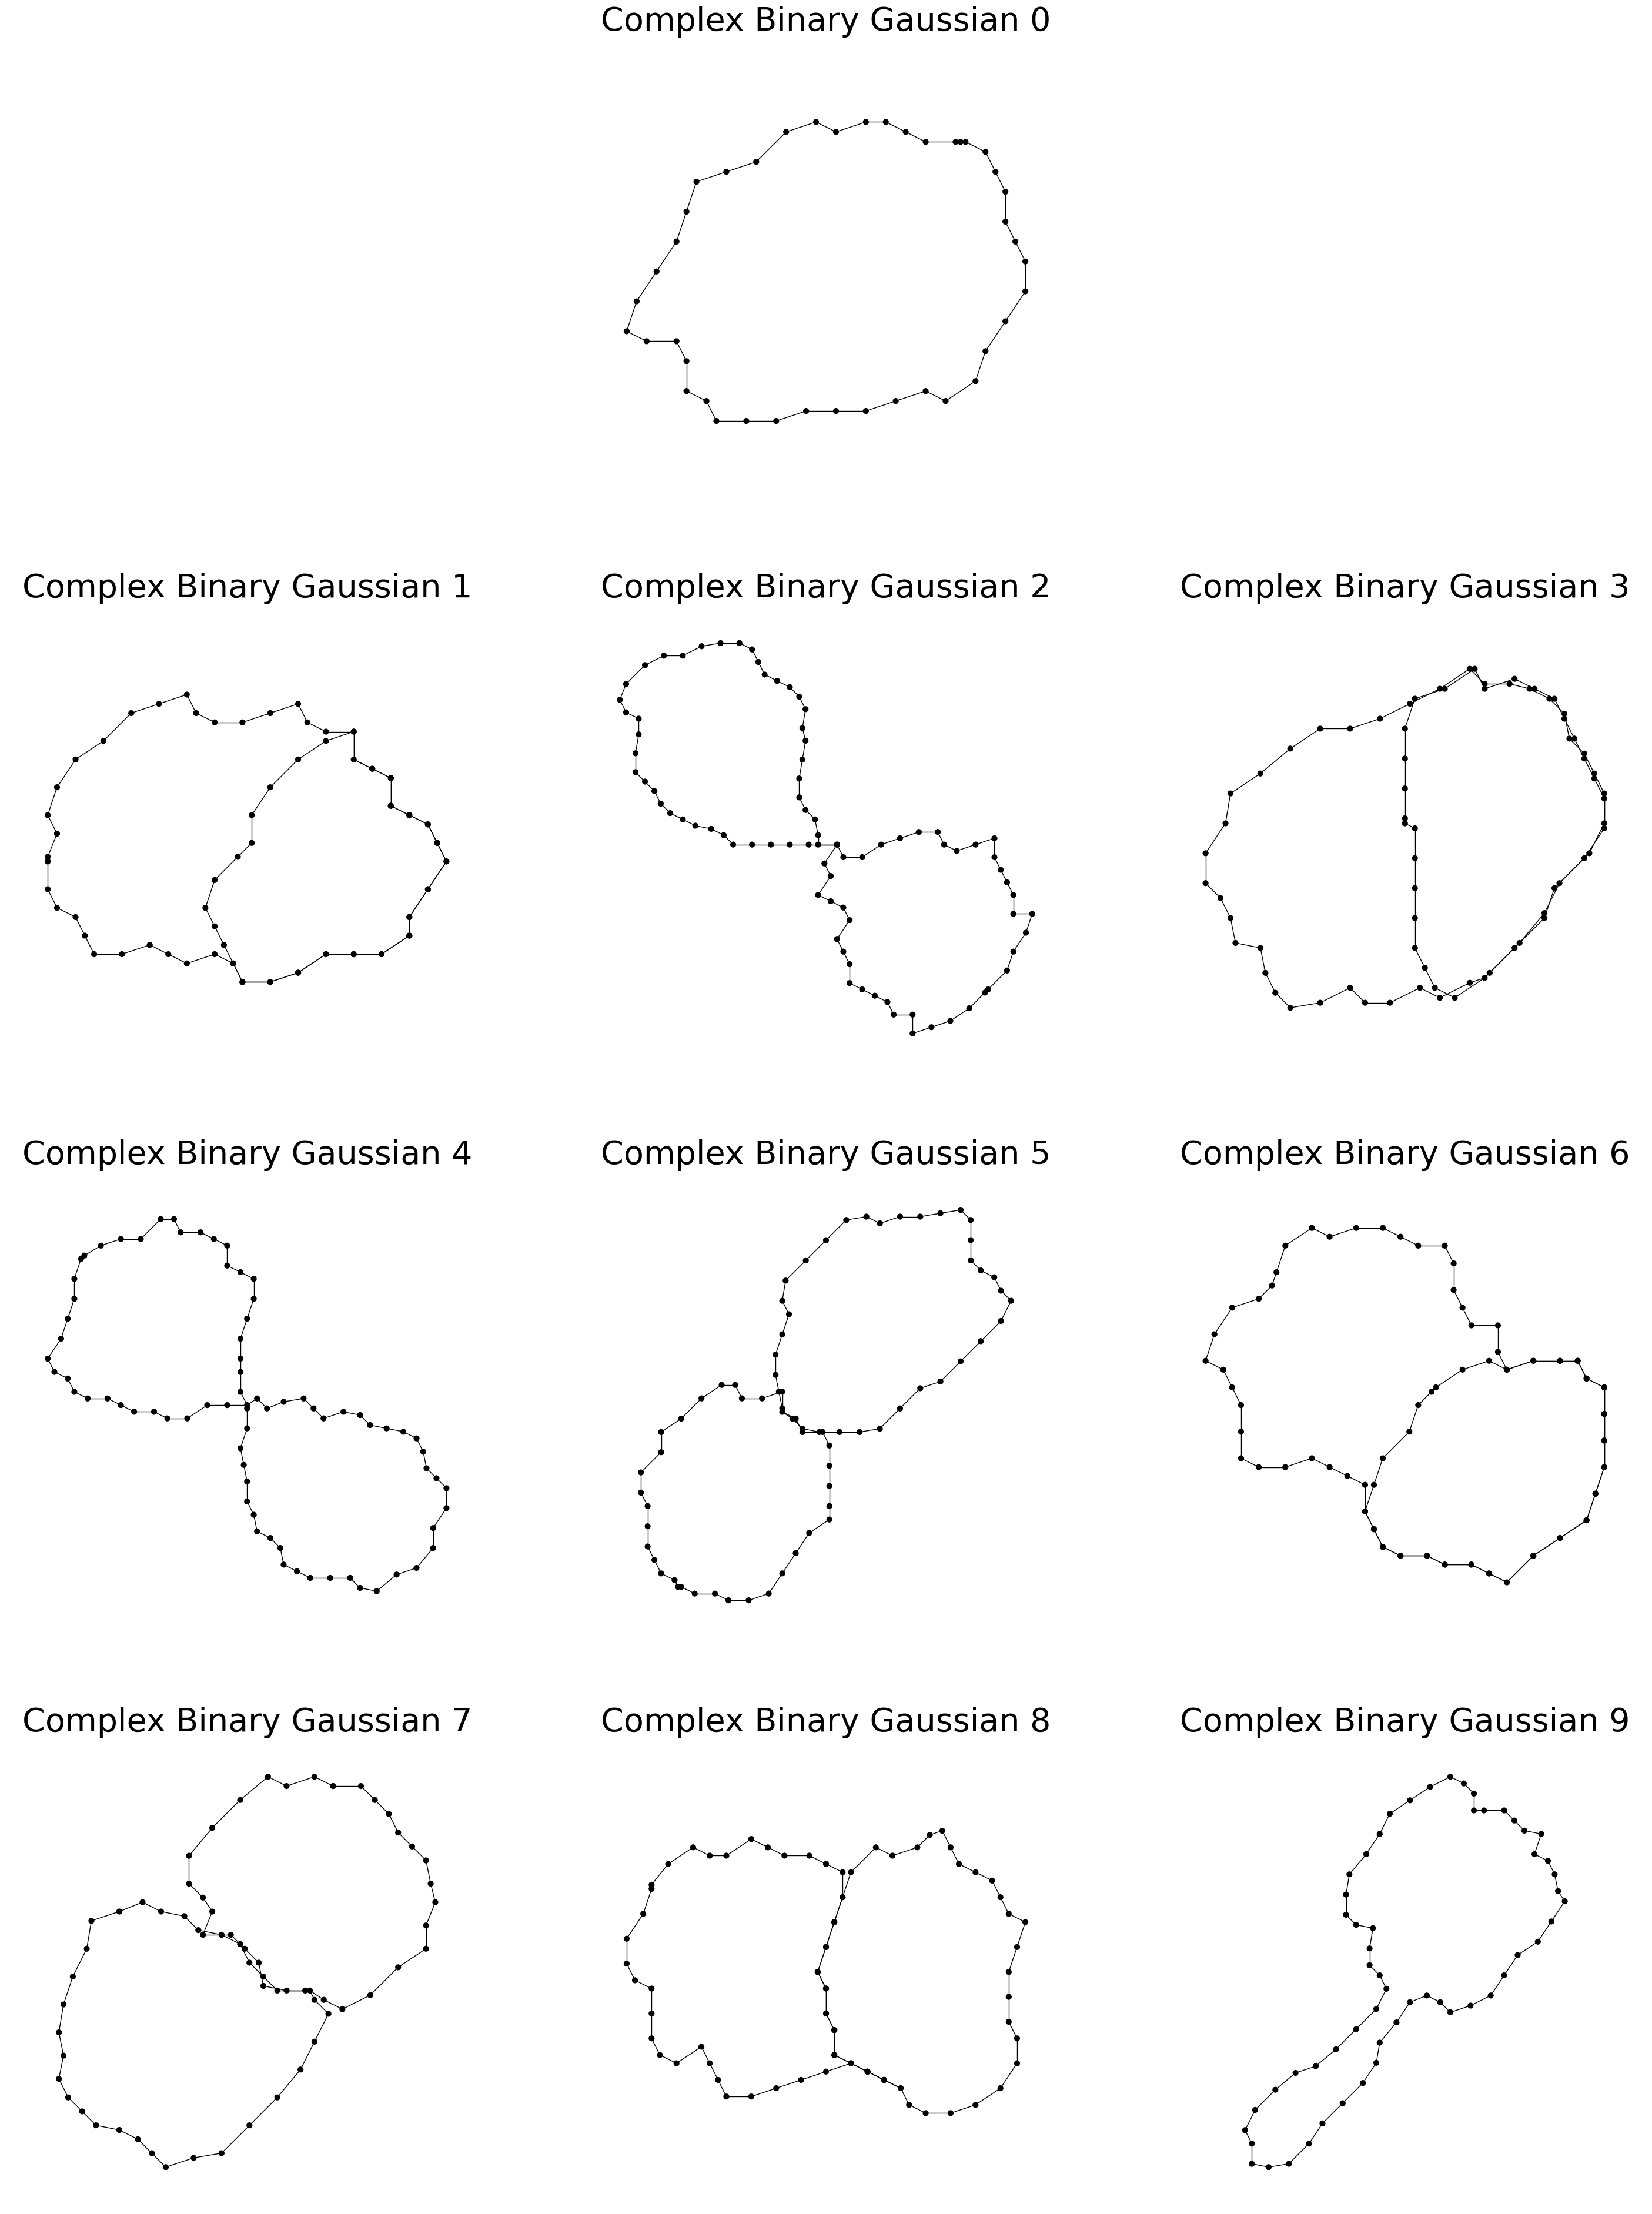

In [7]:
draw_bi_graphs();

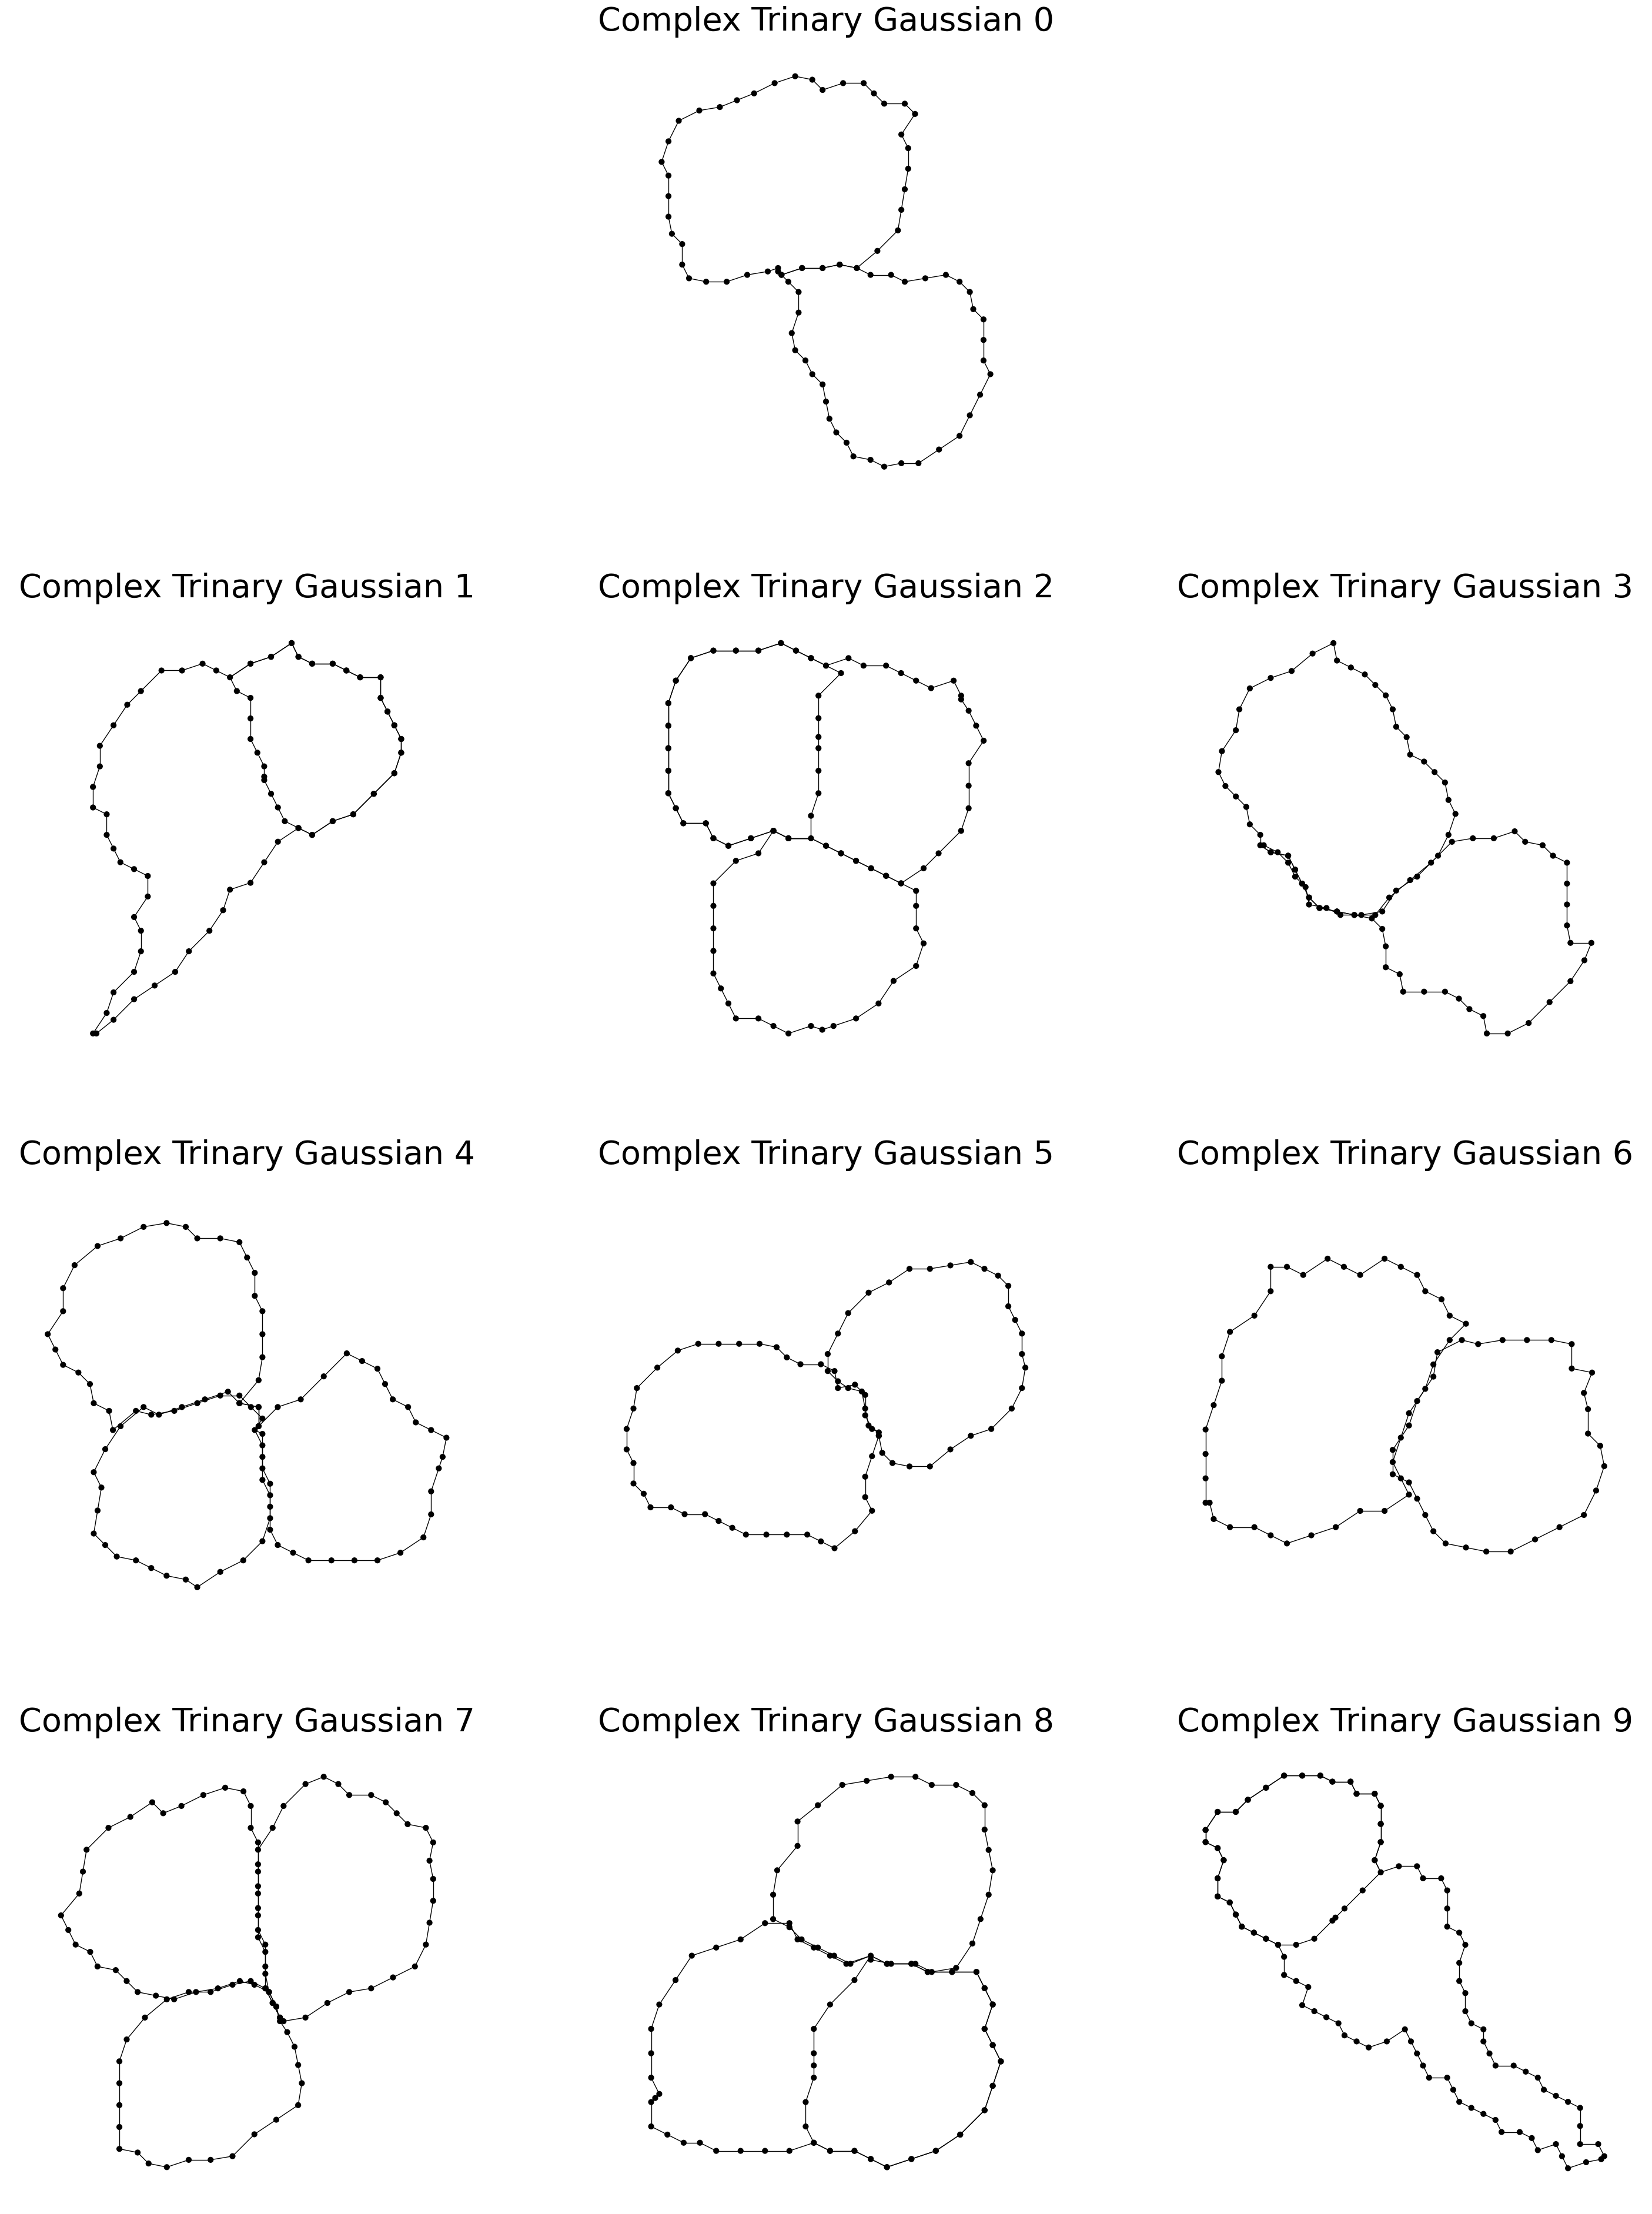

In [8]:
draw_tri_graphs();

In [9]:
graphs = []
nets = []

bi_rev_map = {}
bi_map = {}

for t, bi_graph in bi_complex_graphs.items():
  graphs.append(bi_graph)
  nets.append(bi_complex_nets[t])
  
  bi_rev_map[len(graphs) - 1] = t
  bi_map[t] = len(graphs) - 1
  
tri_rev_map = {}
tri_map = {}
for t, tri_graph in tri_complex_graphs.items():
  graphs.append(tri_graph)
  nets.append(tri_complex_nets[t])
  
  tri_rev_map[len(graphs) - 1] = t
  tri_map[t] = len(graphs) - 1

In [10]:
attributes = np.empty(shape = (len(graphs), len(graphs)), dtype=object)

for i, src in enumerate(graphs):
  attributes[i, i] = np.zeros(1)
  
  for j, dest in enumerate(graphs):
    attributes[i, j] = MorseGraph.attribute_cost_matrix(src, dest)
    
attributes.shape

m = np.max([A.max() for A in attributes.ravel()])

attributes /= m

In [11]:
num_random_iter = 10
random_state = np.random.default_rng(42)

gw_distances = np.zeros(shape = (len(graphs), len(graphs)))
gw_couplings = np.empty(shape = (len(graphs), len(graphs)), dtype=object)

for i, src_net in enumerate(nets):
  gw_distances[i, i] = 0
  
  for j, dest_net in enumerate(nets):
    
    min_coupling = None
    min_dist = float('inf')
    
    for _ in range(num_random_iter):
      coupling, dist = ot.GW(src_net, dest_net, random_G0=True, random_state=random_state)
      
      if dist < min_dist:
        min_dist = dist
        min_coupling = coupling
    
    gw_distances[i, j] = min_dist
    gw_couplings[i, j] = min_coupling

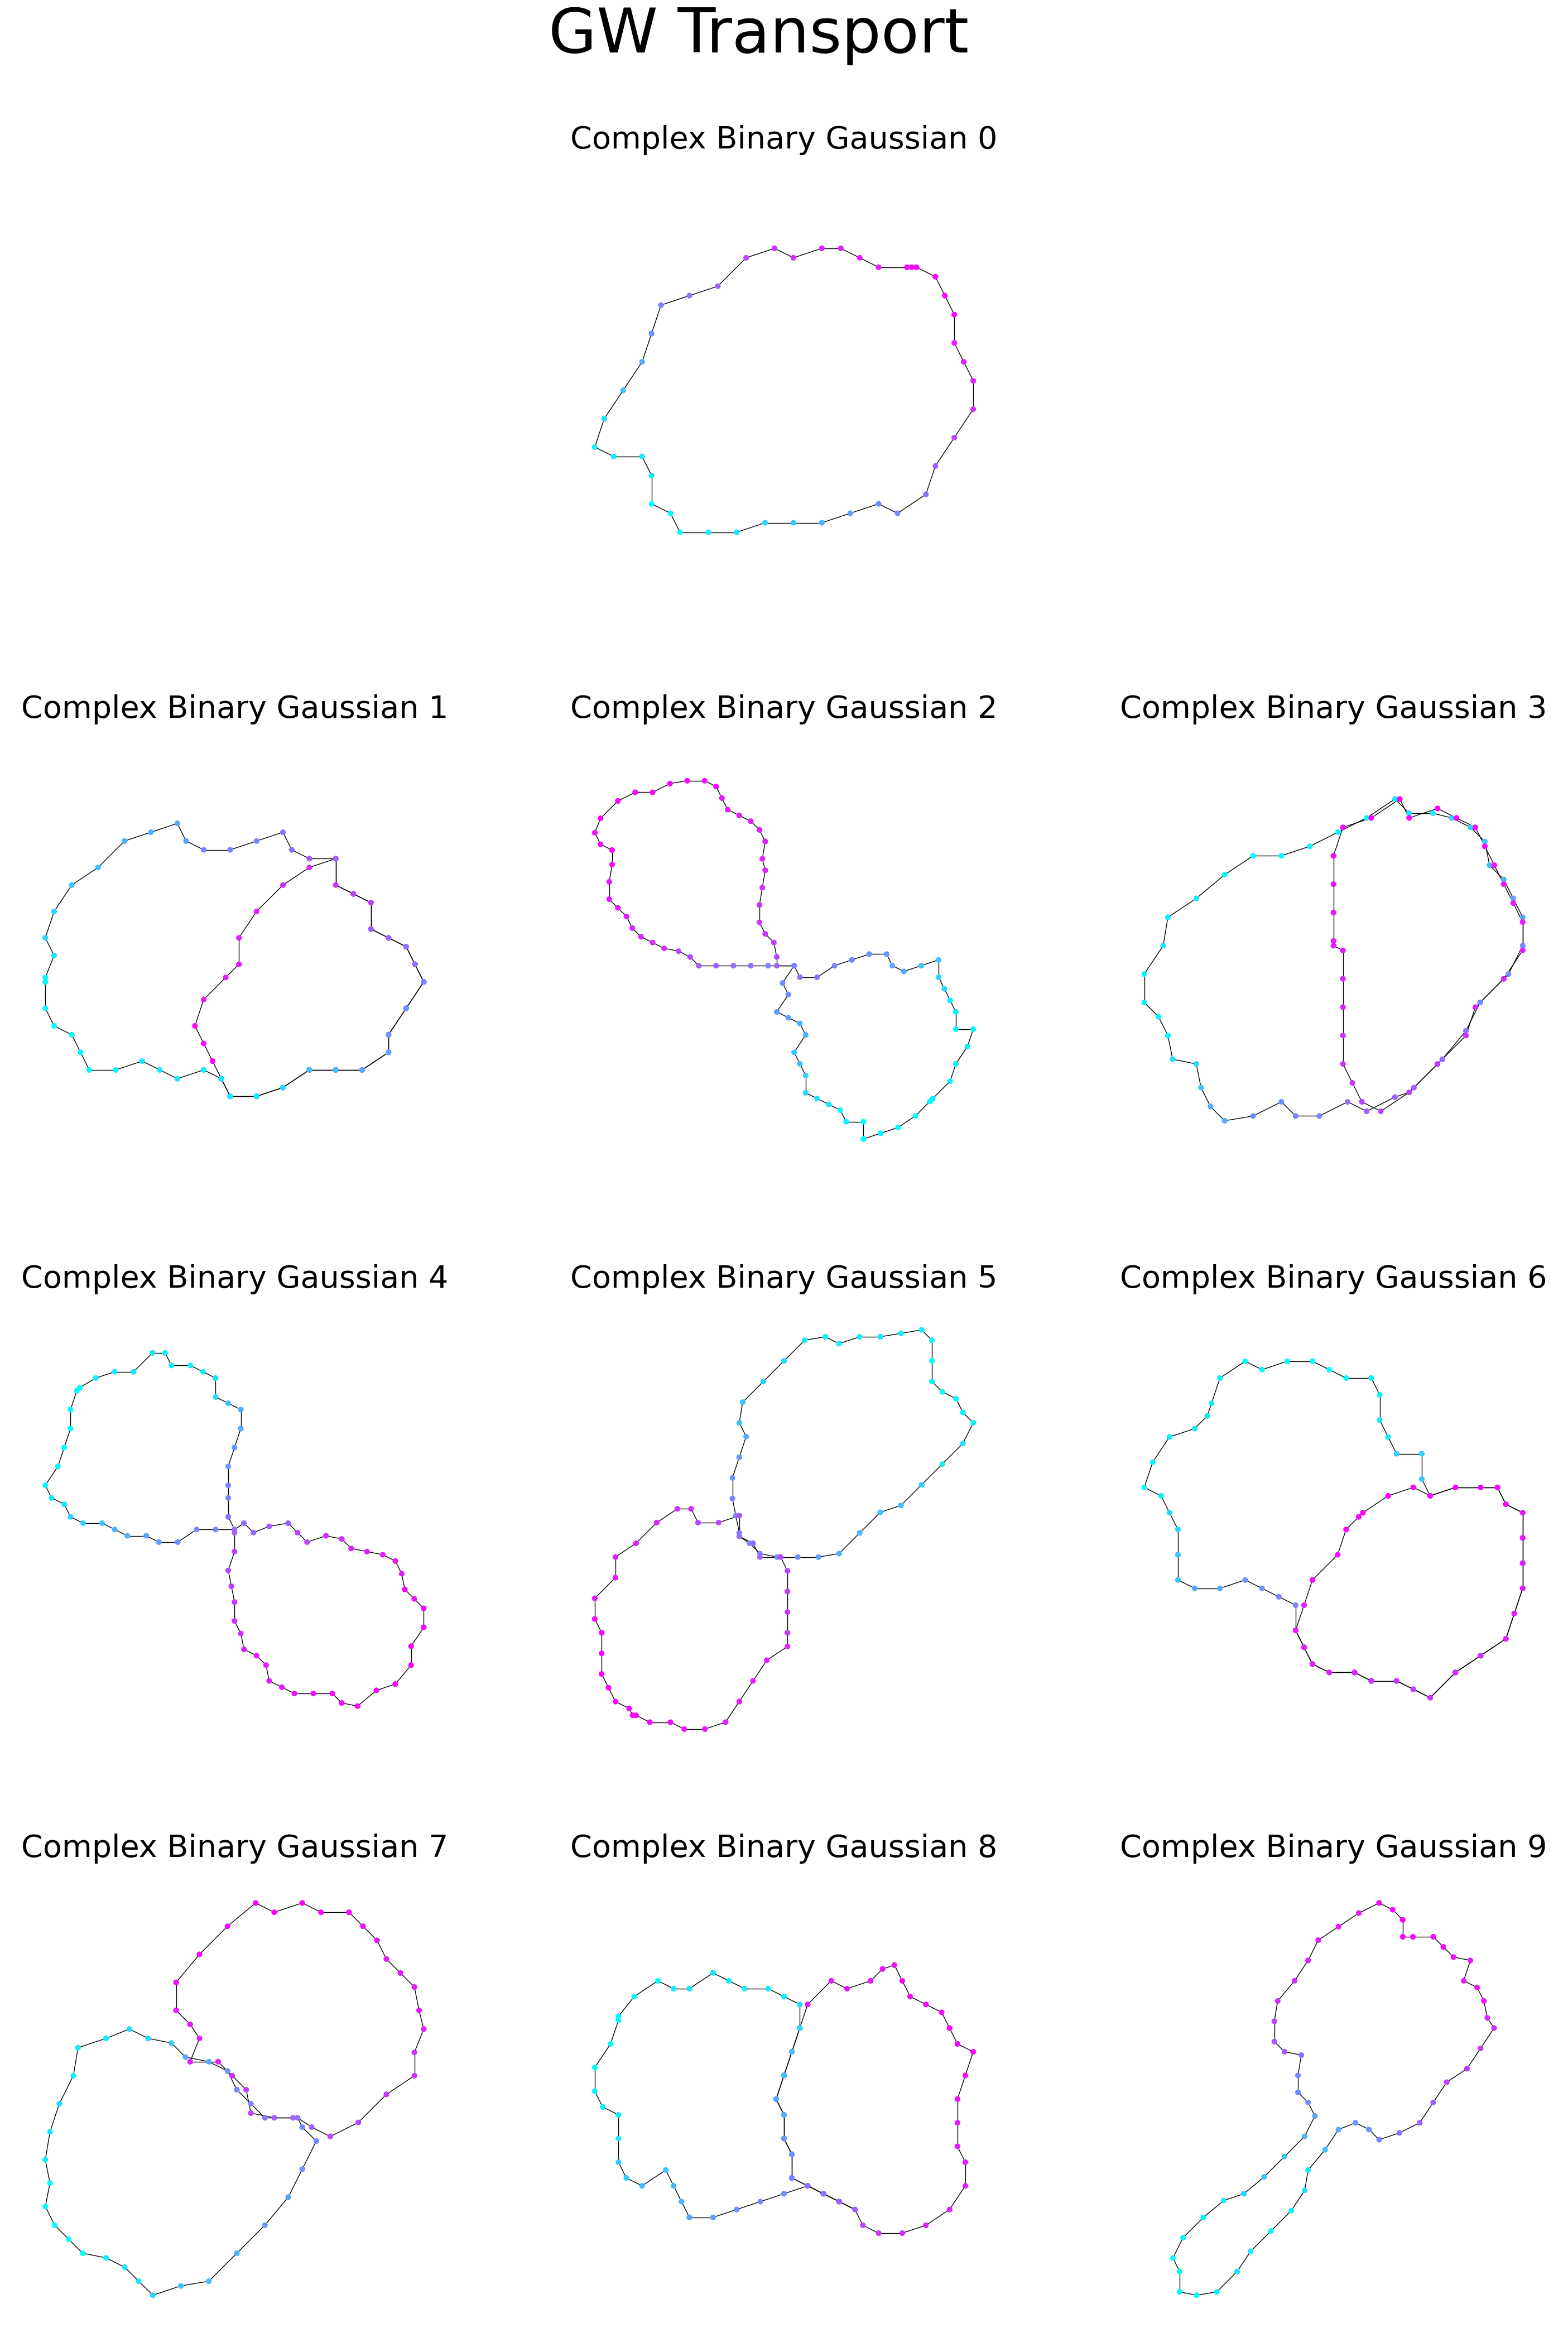

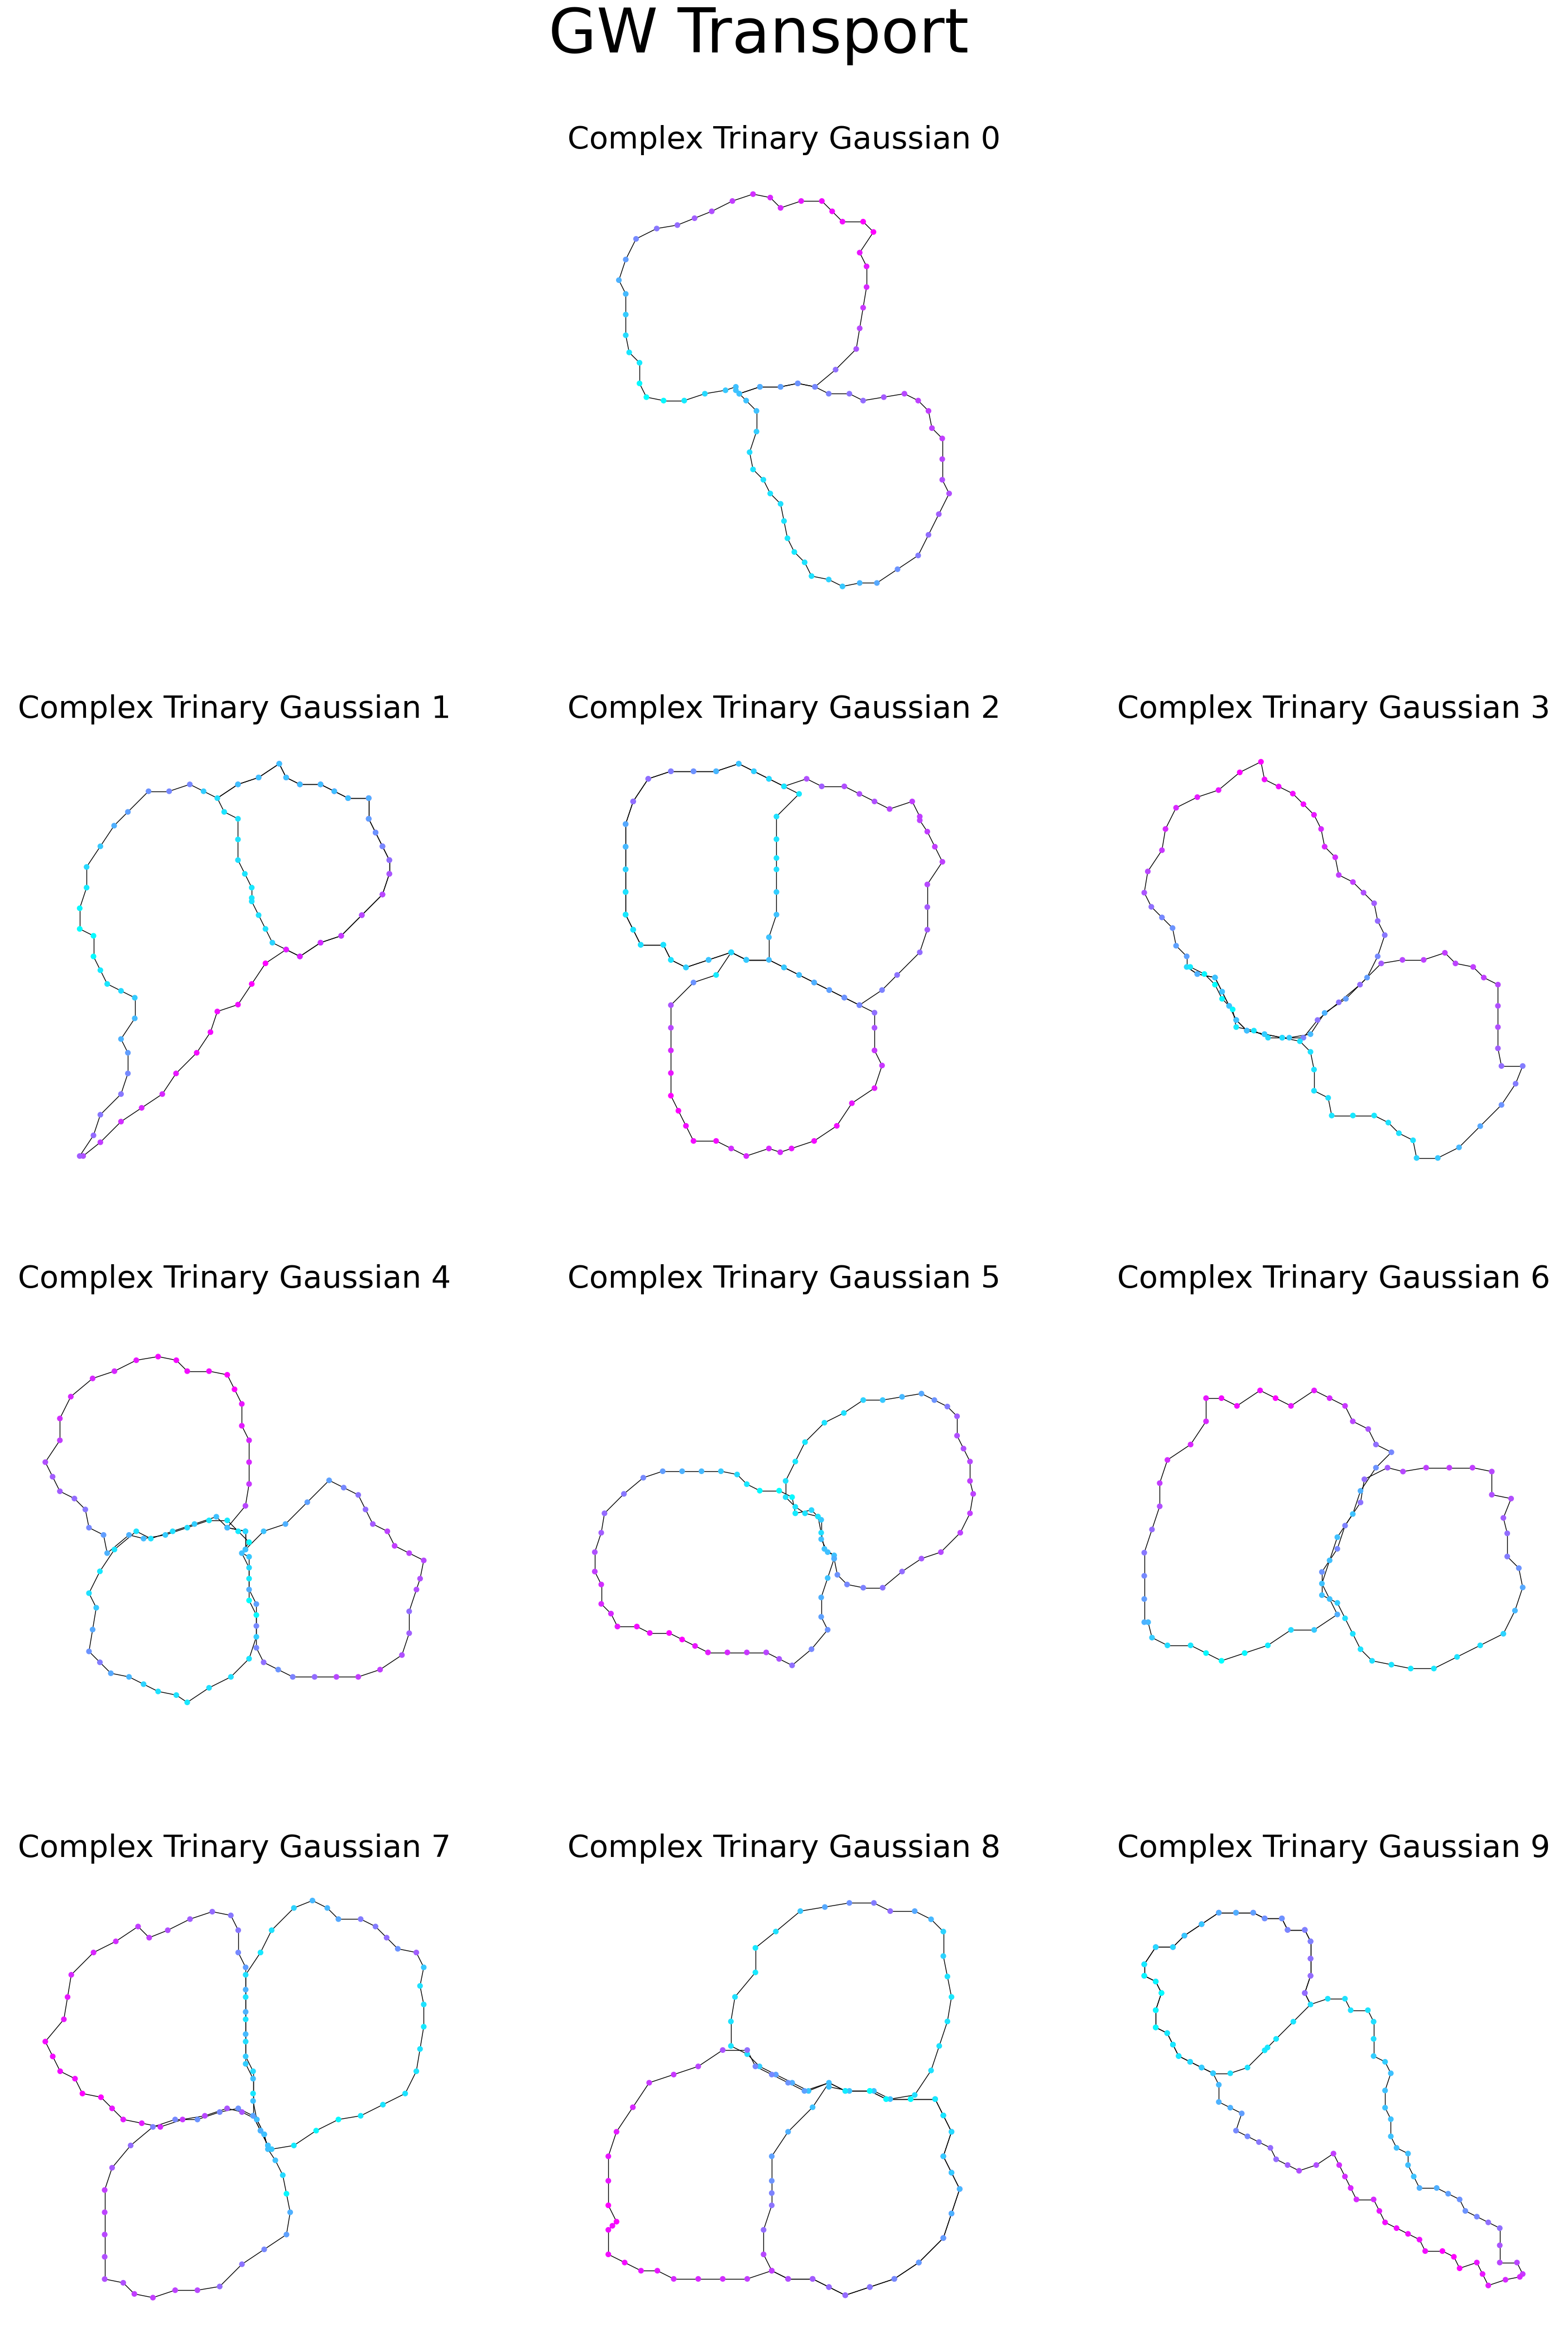

In [12]:
bi_gw_couplings = {t : gw_couplings[bi_map[0], bi_map[t]] for t in bi_complex_graphs.keys()}
bi_gw_couplings.pop(0)

fig = draw_bi_graphs(
  couplings=bi_gw_couplings
)
fig.suptitle('GW Transport', fontsize = 80)
fig.subplots_adjust(top=0.925)

tri_gw_couplings = {t : gw_couplings[tri_map[0], tri_map[t]] for t in tri_complex_graphs.keys()}

fig = draw_tri_graphs(
  couplings=tri_gw_couplings
)
fig.suptitle('GW Transport', fontsize = 80)
fig.subplots_adjust(top=0.925)

In [13]:
fgw_distances = np.zeros(shape = (len(graphs), len(graphs)))
fgw_couplings = np.empty(shape = (len(graphs), len(graphs)), dtype=object)

for i, src_net in enumerate(nets):
  fgw_distances[i, i] = 0
  
  for j, dest_net in enumerate(nets):
    if i == j:
      fgw_couplings[i, j] = None
      fgw_distances[i, j] = 0
      continue
    
    fgw_couplings[i, j], fgw_distances[i, j] = ot.fGW(src_net, dest_net, M = attributes[i, j], alpha=0.5)

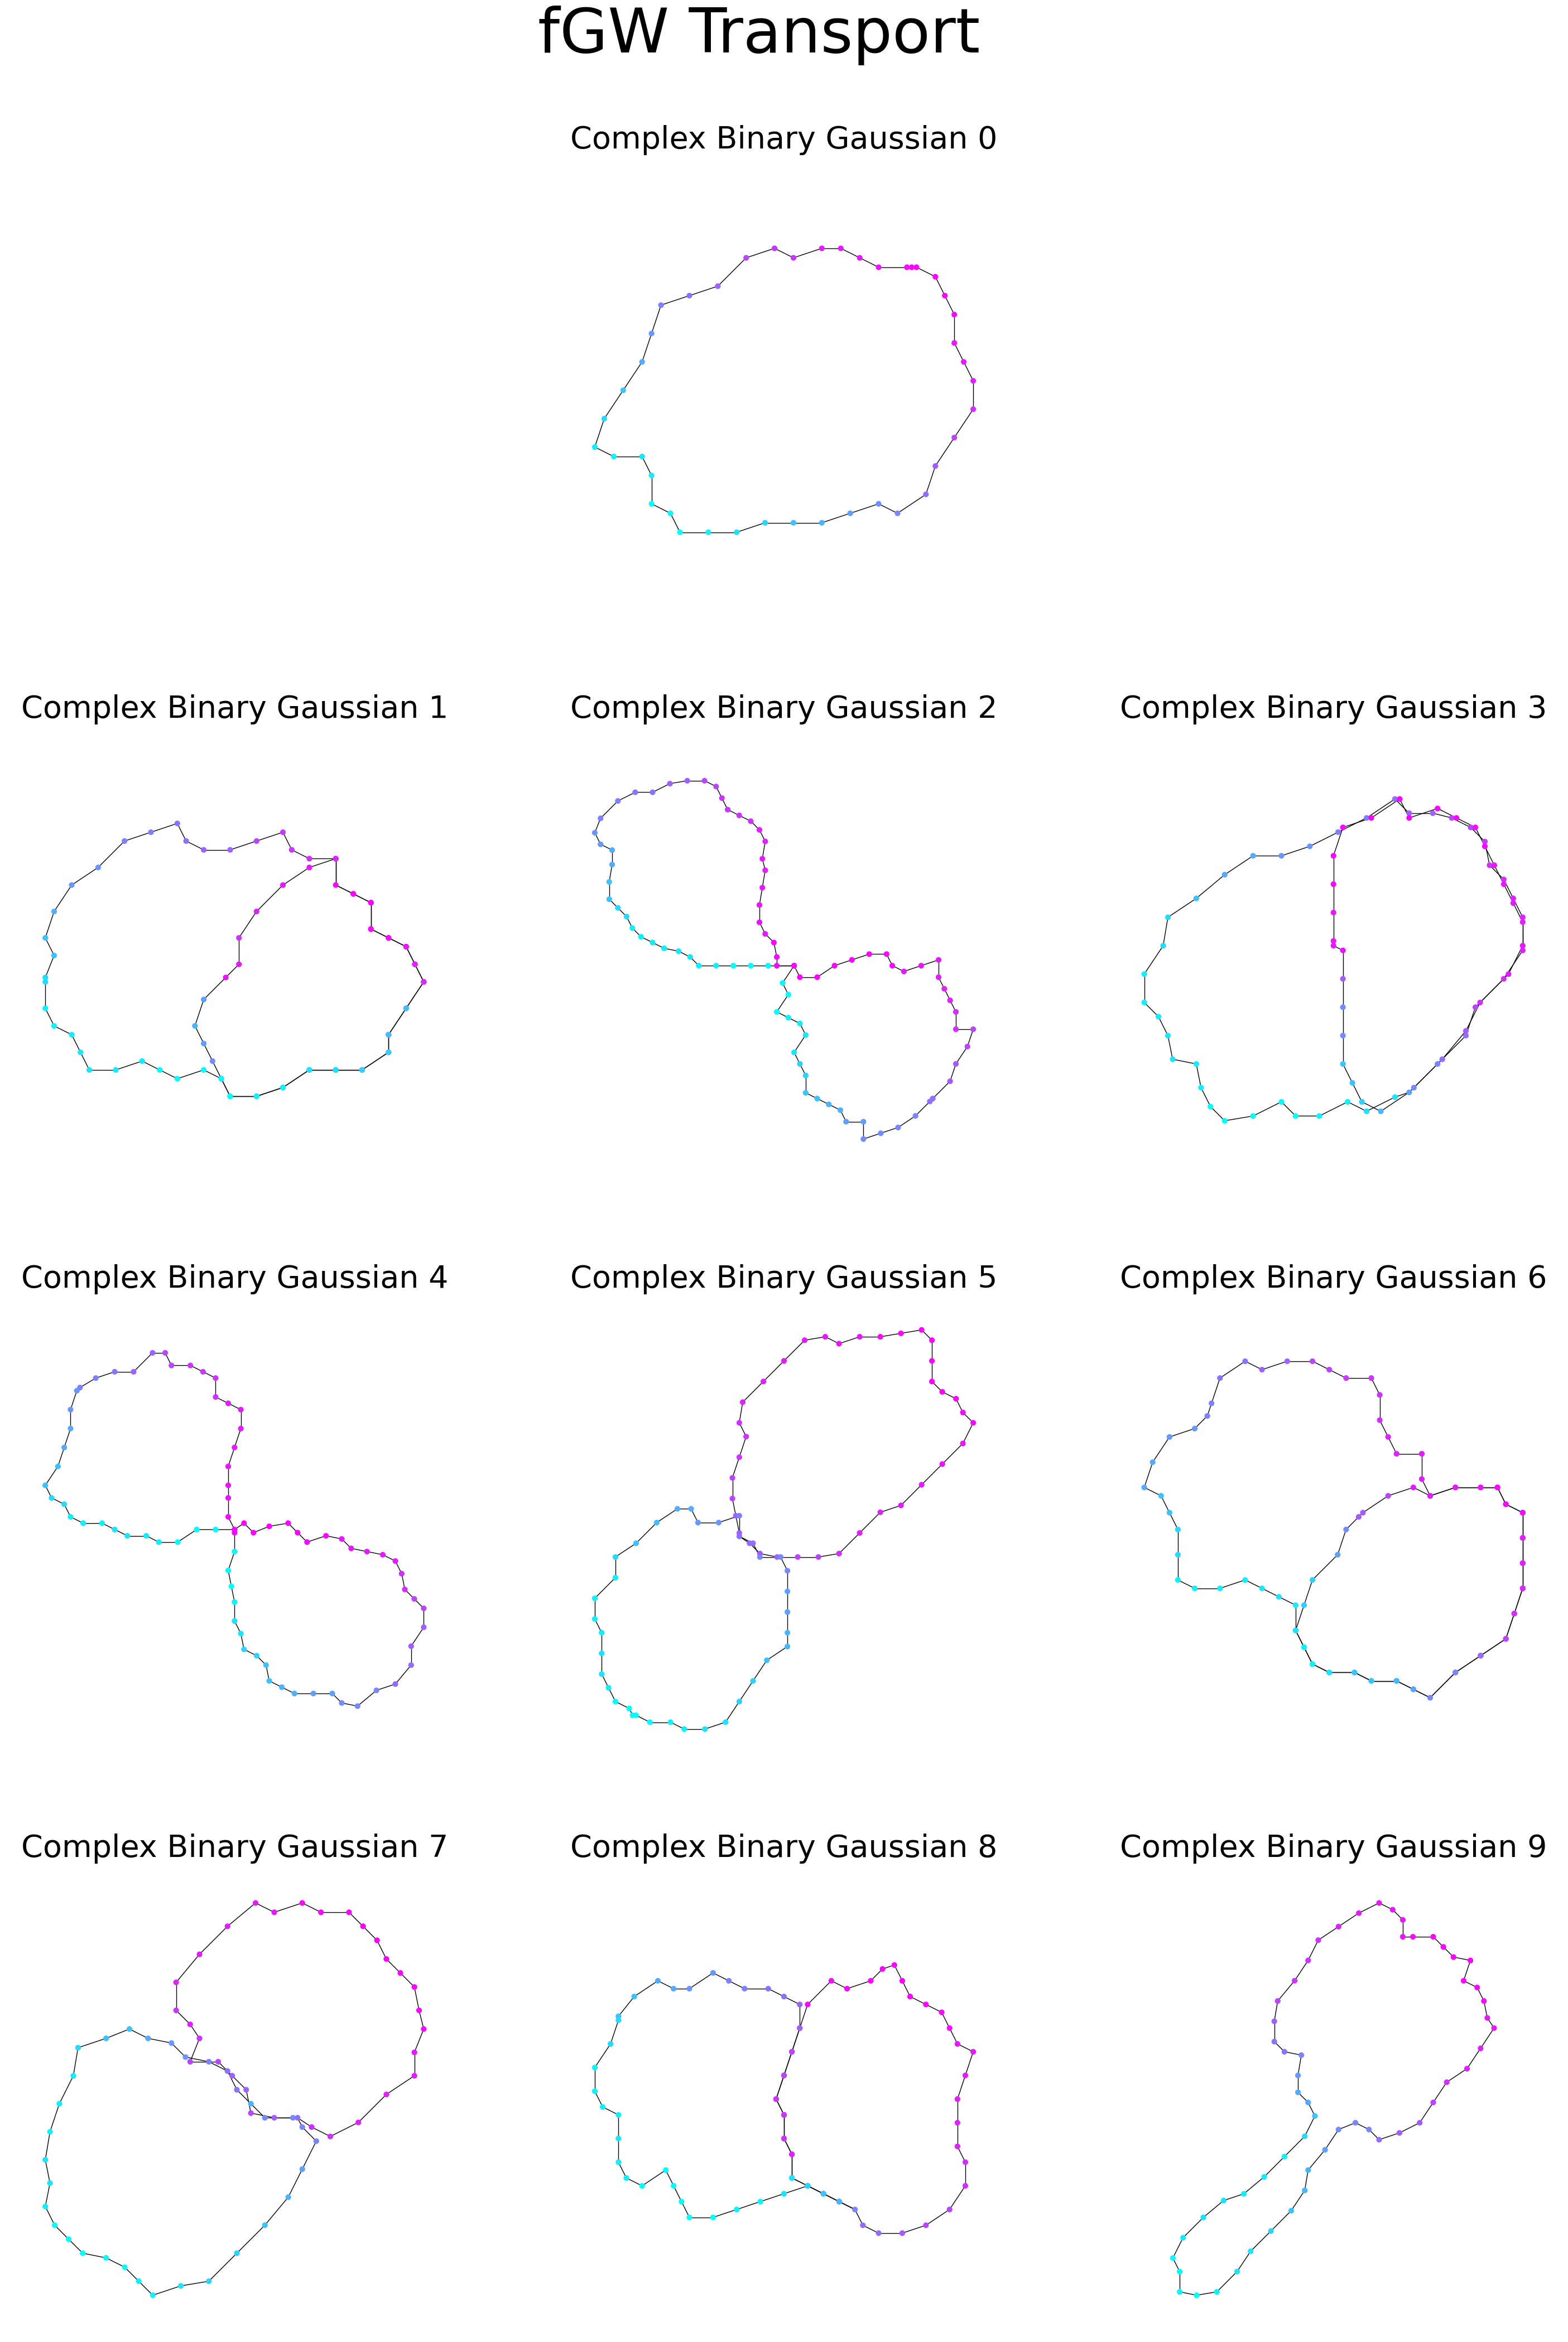

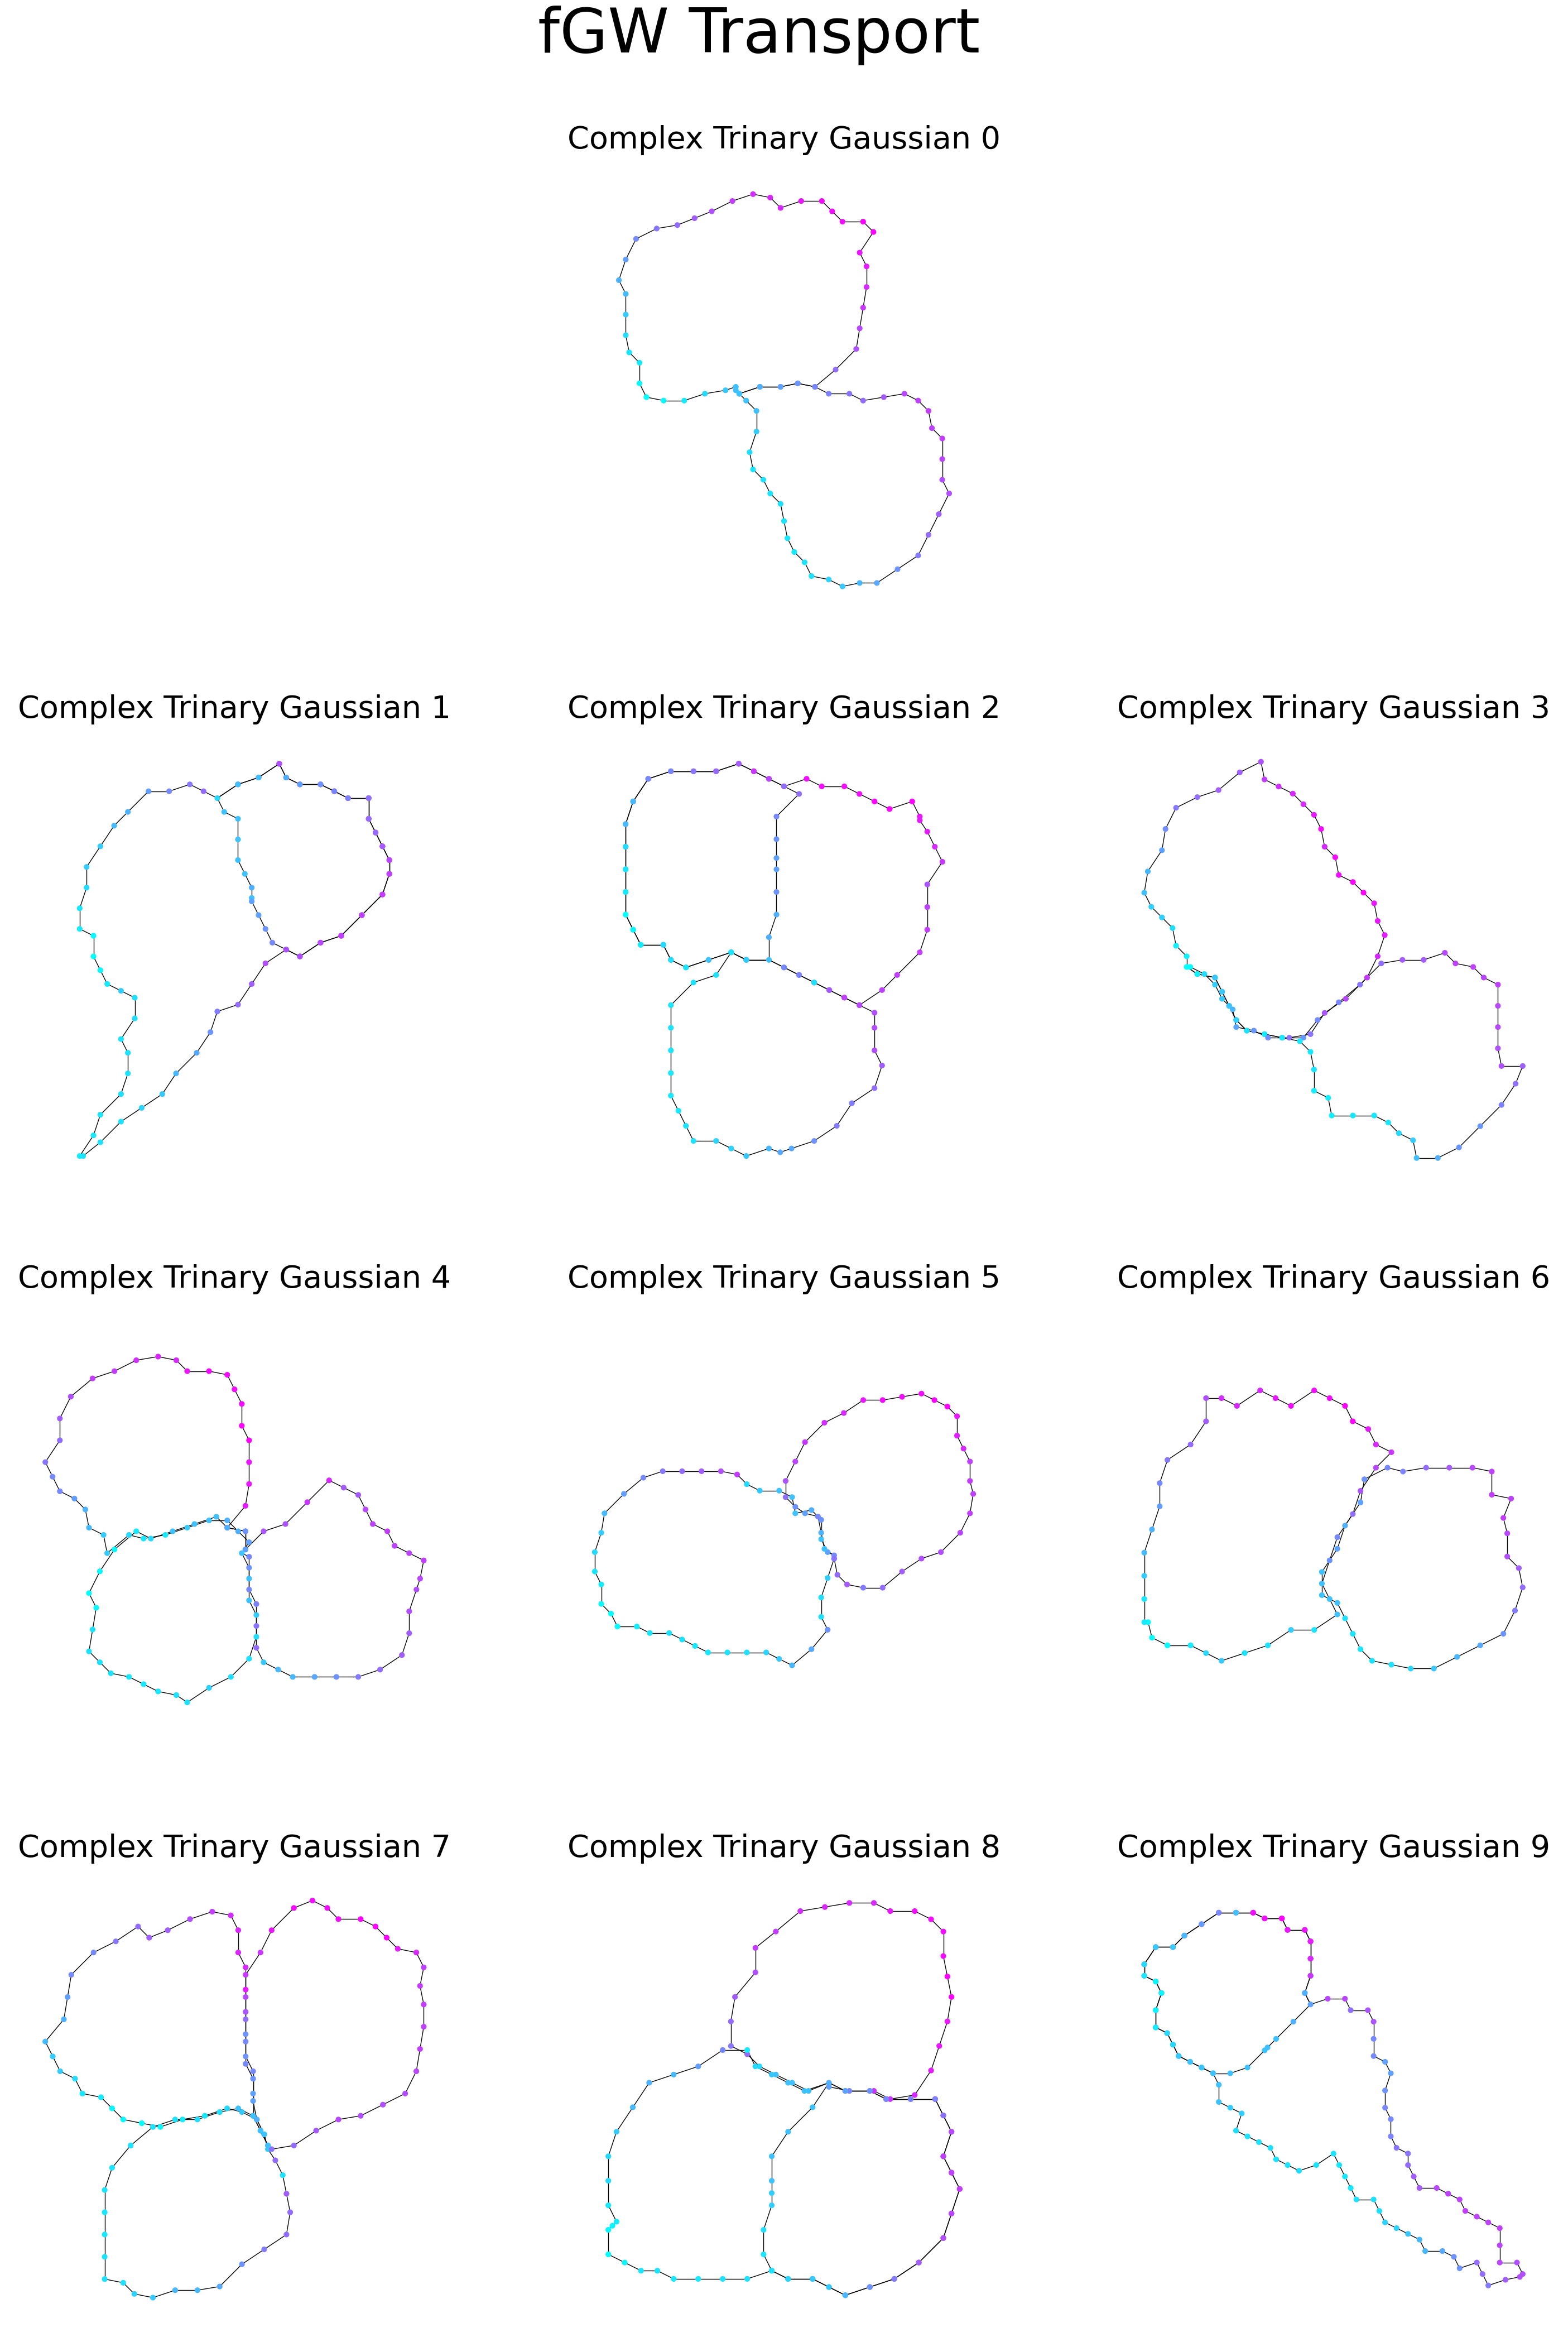

In [14]:
bi_fgw_couplings = {t : fgw_couplings[bi_map[0], bi_map[t]] for t in bi_complex_graphs.keys()}
bi_fgw_couplings.pop(0)

fig = draw_bi_graphs(
  couplings=bi_fgw_couplings
)
fig.suptitle('fGW Transport', fontsize = 80)
fig.subplots_adjust(top=0.925)

tri_fgw_couplings = {t : fgw_couplings[tri_map[0], tri_map[t]] for t in tri_complex_graphs.keys()}

fig = draw_tri_graphs(
  couplings=tri_fgw_couplings
)
fig.suptitle('fGW Transport', fontsize = 80)
fig.subplots_adjust(top=0.925)

In [15]:
wasserstein_distances = np.zeros(shape = (len(graphs), len(graphs)))
wasserstein_couplings = np.empty(shape = (len(graphs), len(graphs)), dtype=object)

for i, src_net in enumerate(nets):
  
  for j, dest_net in enumerate(nets):
    if i == j:
      wasserstein_couplings[i, j] = None
      wasserstein_distances[i, j] = 0
      continue
    
    wasserstein_couplings[i, j], wasserstein_distances[i, j] = ot.Wasserstein(src_net, dest_net, M = attributes[i, j])

In [16]:
for i in range(wasserstein_distances.shape[0]):
  for j in range(i):
    wasserstein_distances[j, i] = wasserstein_distances[i, j]

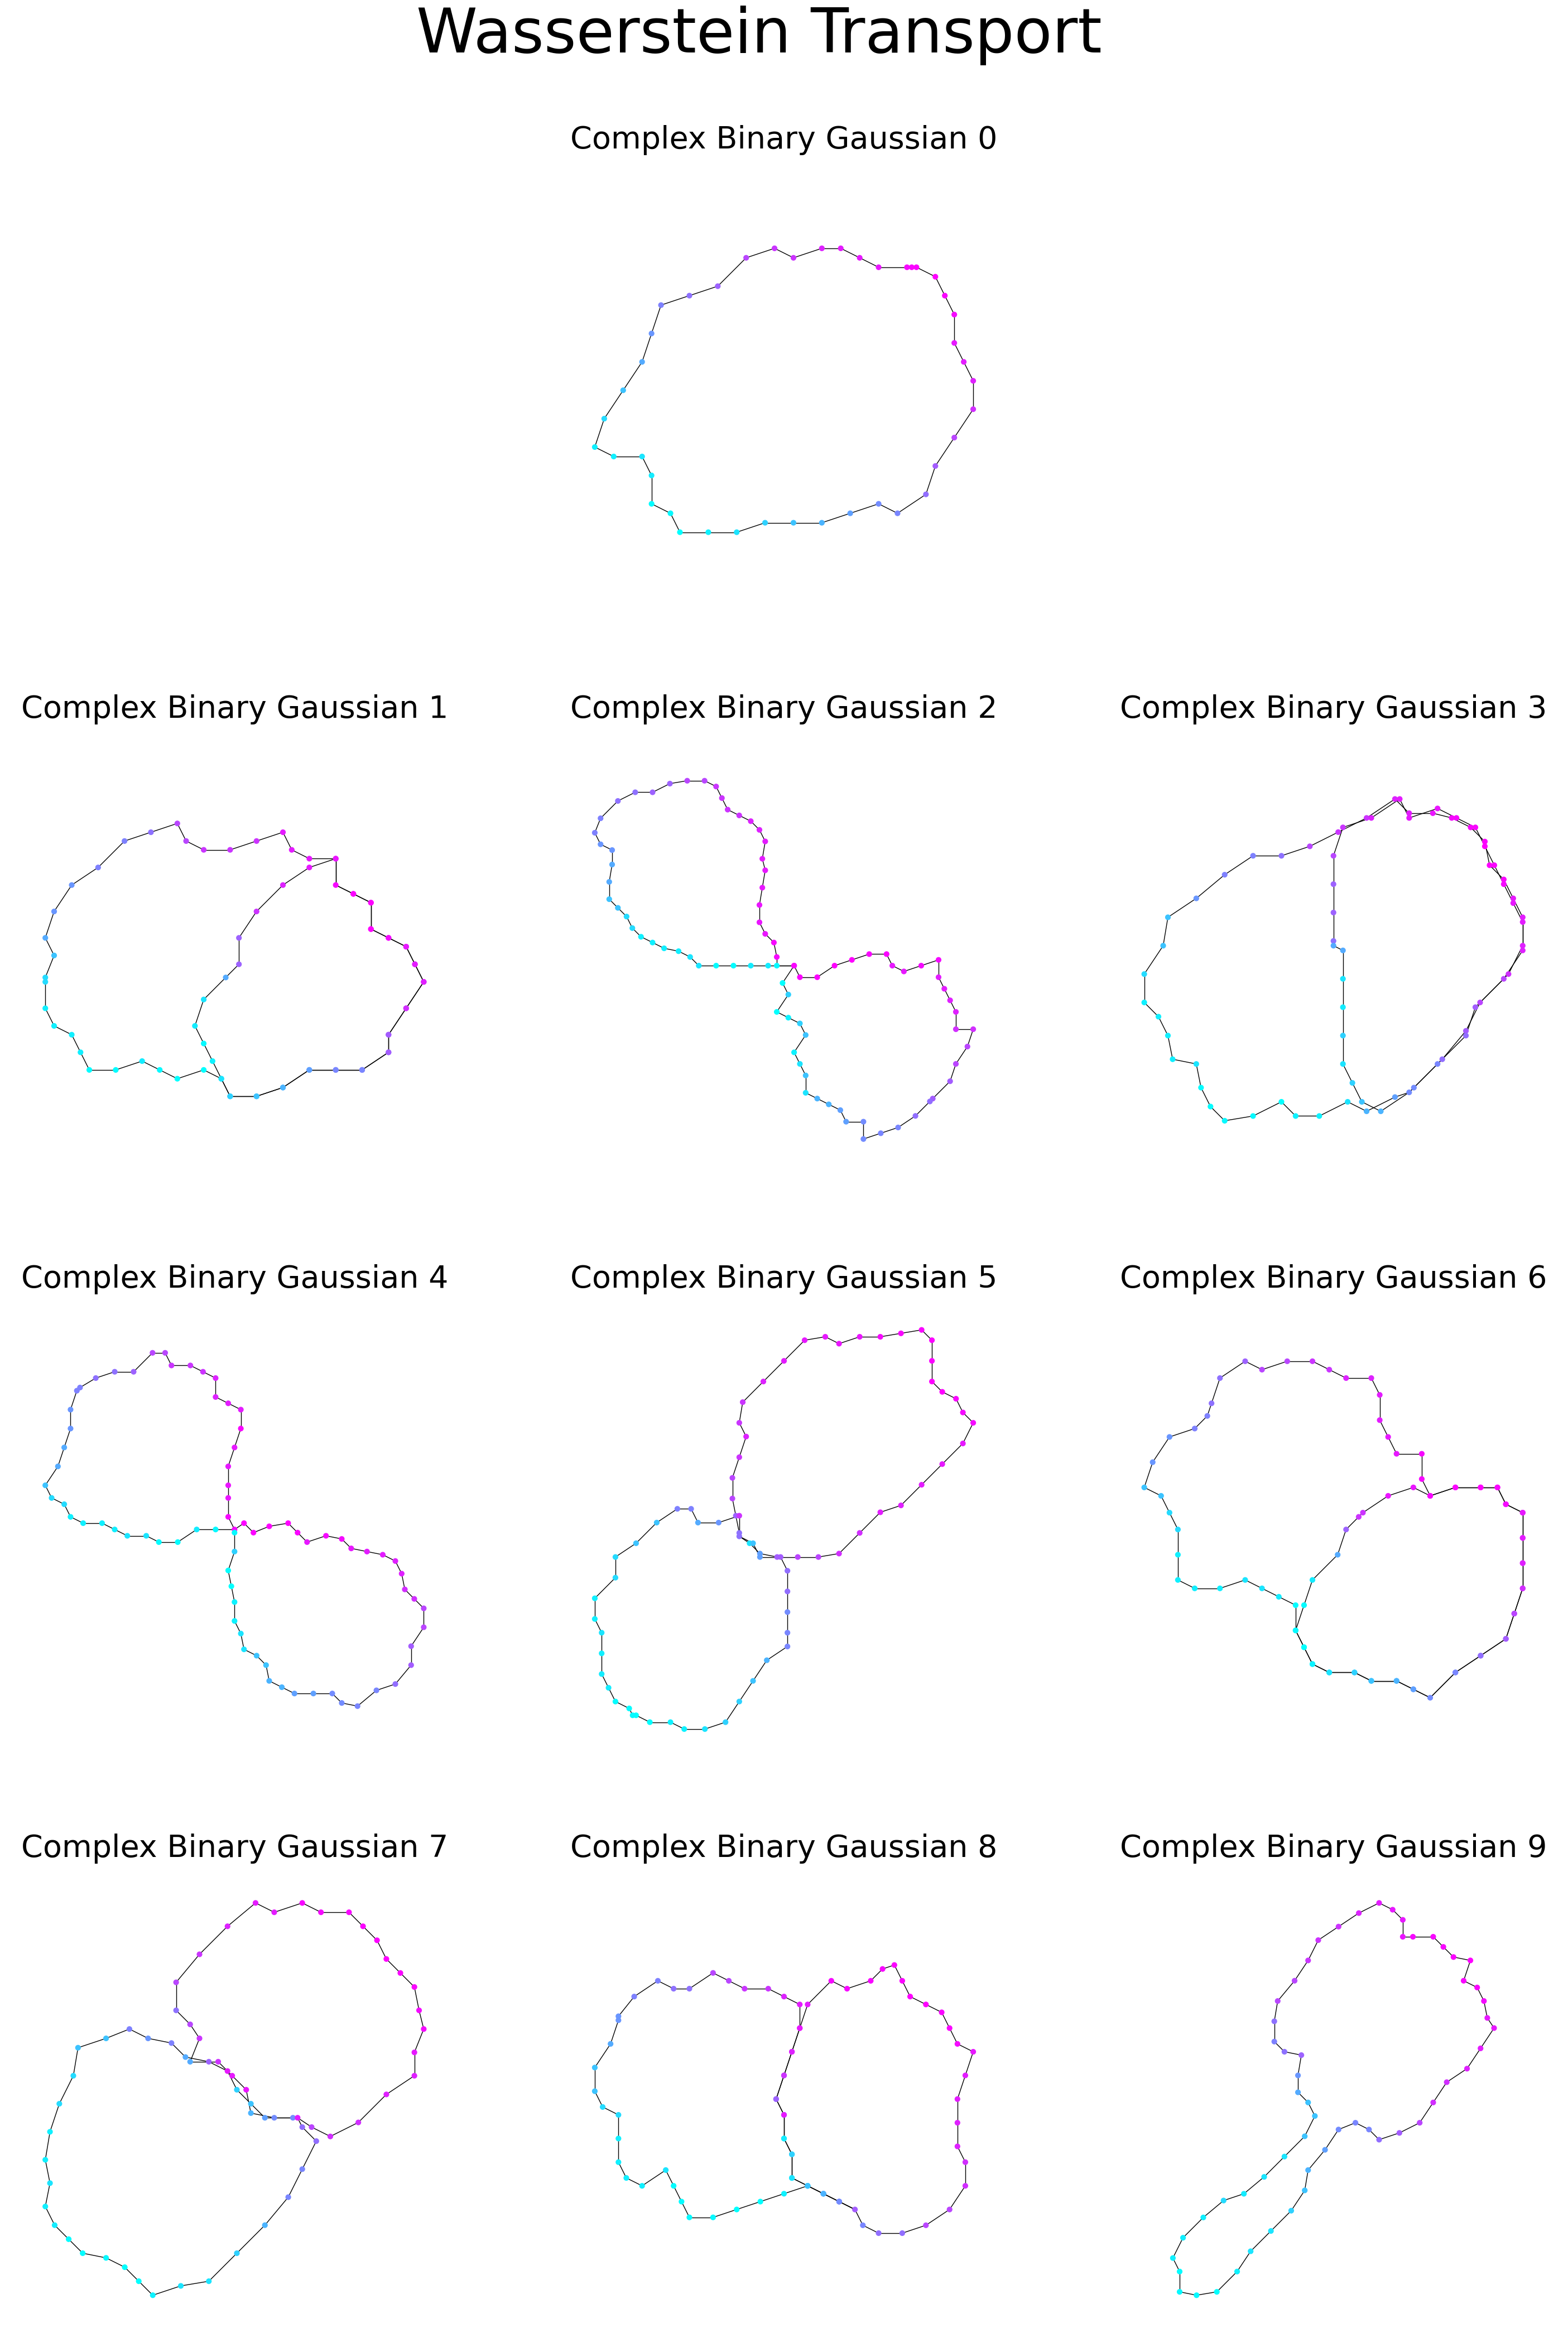

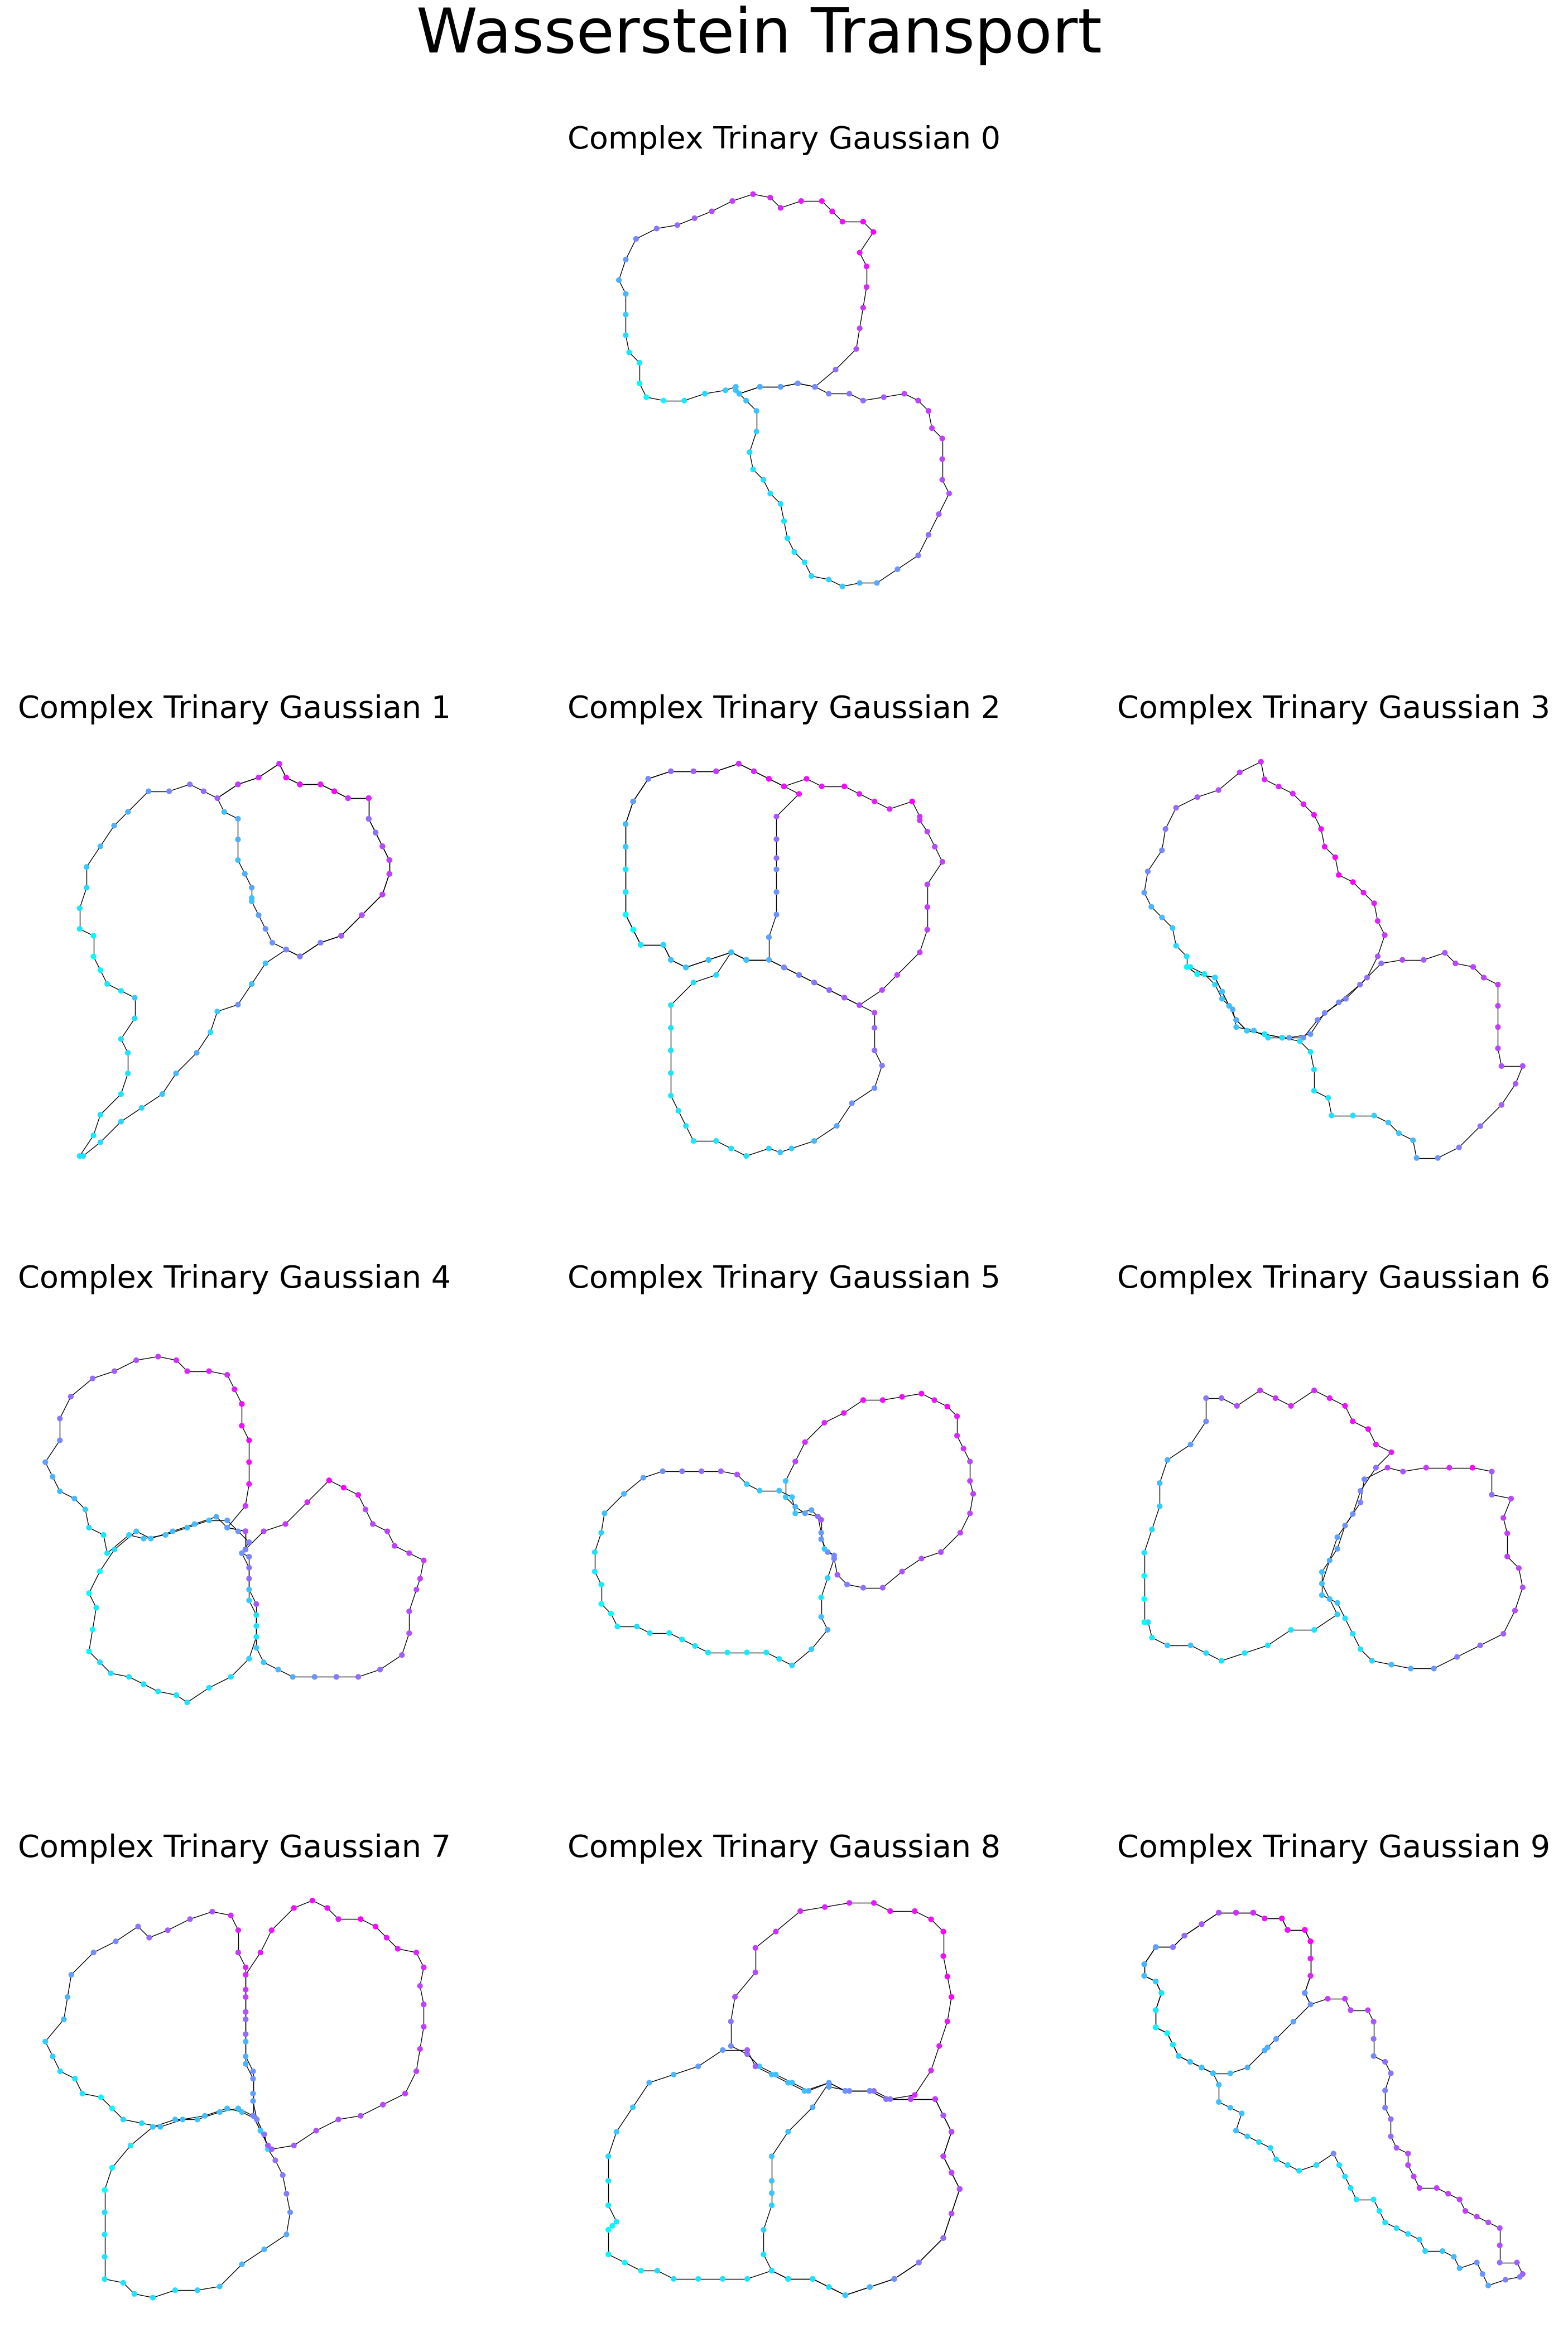

In [17]:
bi_w_couplings = {t : wasserstein_couplings[bi_map[0], bi_map[t]] for t in bi_complex_graphs.keys()}
bi_w_couplings.pop(0)

fig = draw_bi_graphs(
  couplings=bi_w_couplings
)
fig.suptitle('Wasserstein Transport', fontsize = 80)
fig.subplots_adjust(top=0.925)

tri_w_couplings = {t : wasserstein_couplings[tri_map[0], tri_map[t]] for t in tri_complex_graphs.keys()}

fig = draw_tri_graphs(
  couplings=tri_w_couplings
)
fig.suptitle('Wasserstein Transport', fontsize = 80)
fig.subplots_adjust(top=0.925)

In [18]:
mds = MDS(random_state=42, dissimilarity='precomputed')

Text(0.5, 1.0, 'Wasserstein')

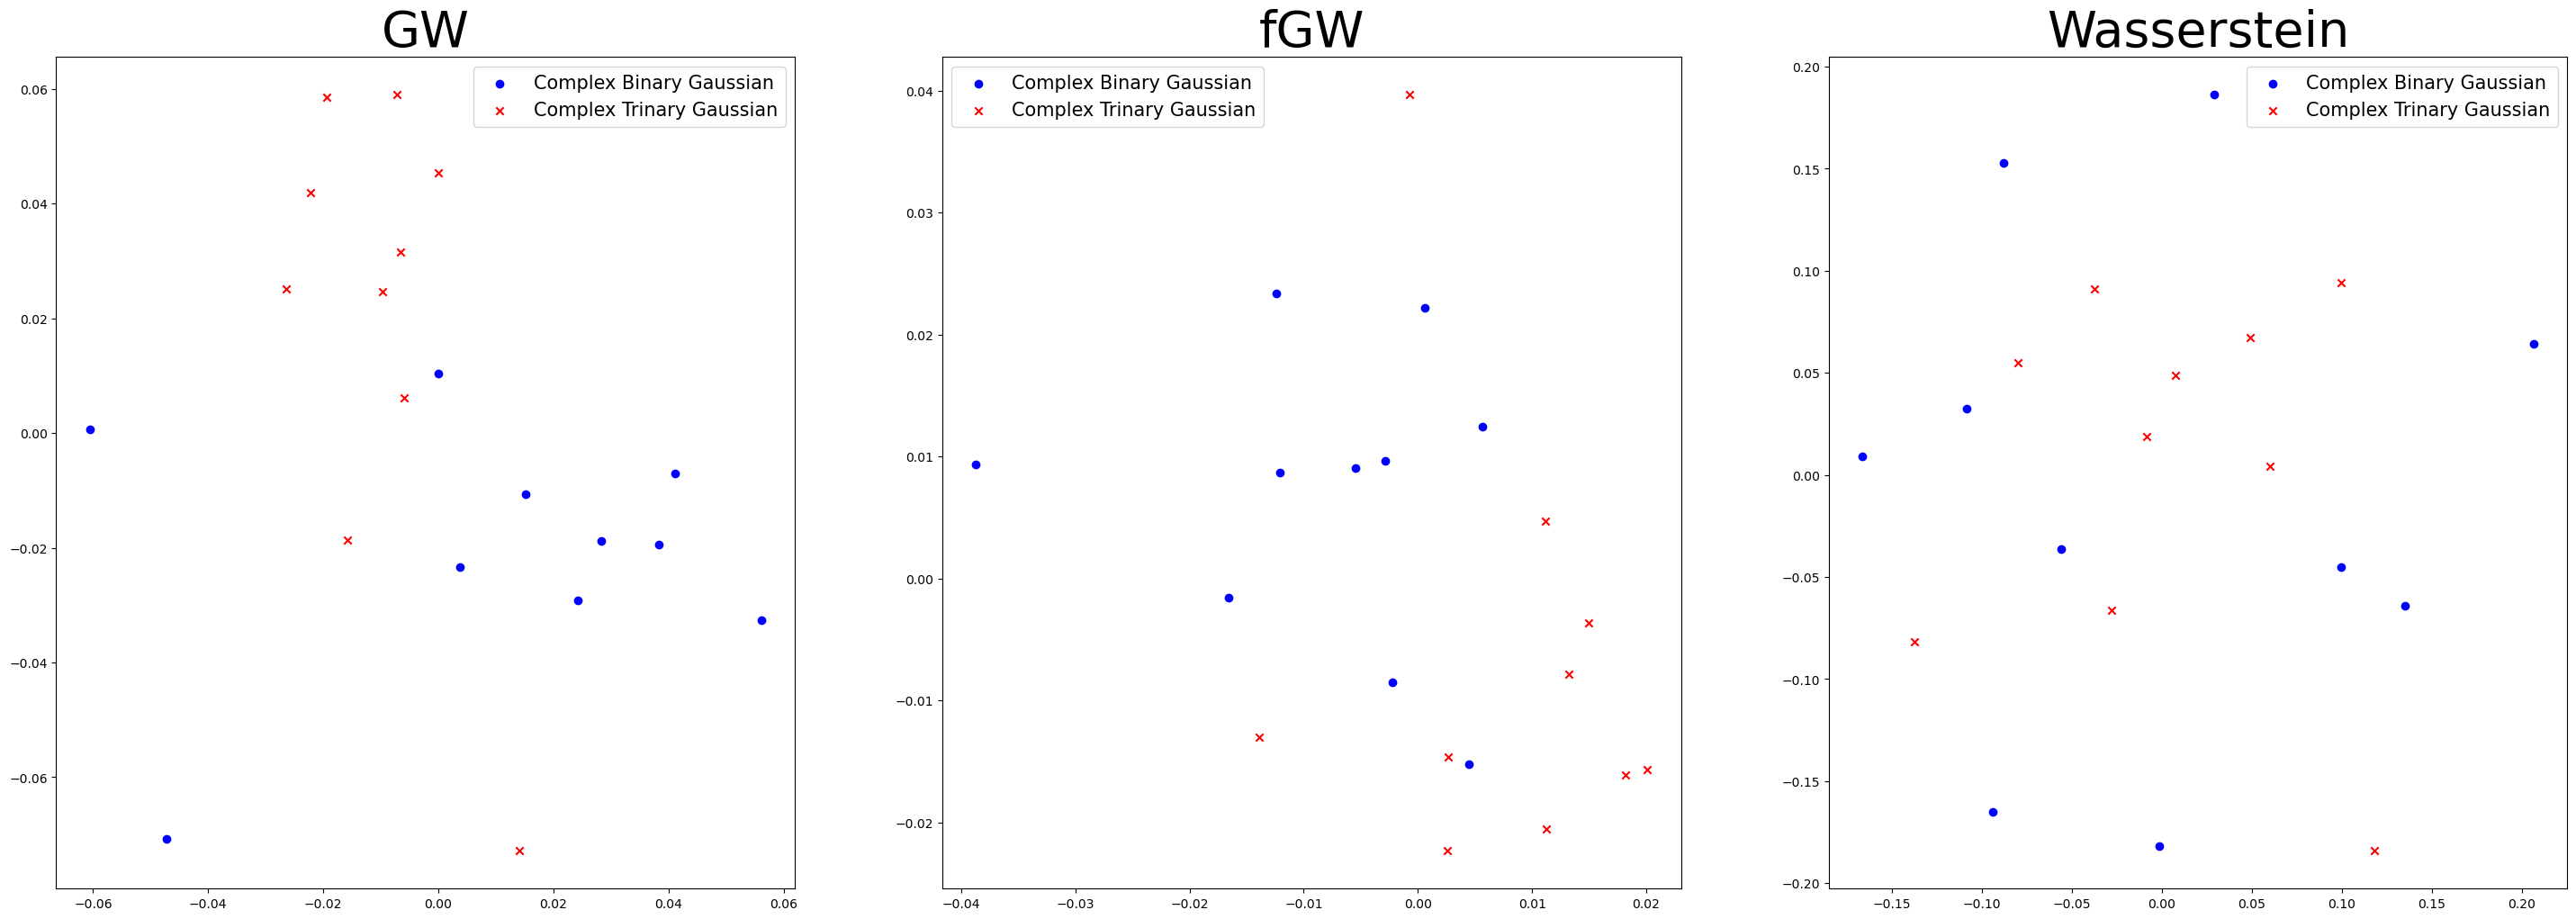

In [20]:
gw_transform = mds.fit_transform(gw_distances)
fgw_transform = mds.fit_transform(fgw_distances)
wasserstein_transform = mds.fit_transform(wasserstein_distances)

fig, axes = plt.subplots(1, 3, figsize=(3 * 12, 12))

bi_gw_transforms = gw_transform[:len(bi_complex_graphs), :]
tri_gw_transforms = gw_transform[len(tri_complex_graphs):, :]

axes[0].scatter(bi_gw_transforms[:, 0], bi_gw_transforms[:, 1], marker='o', c='blue', label='Complex Binary Gaussian')
axes[0].scatter(tri_gw_transforms[:, 0], tri_gw_transforms[:, 1], marker='x', c='red', label='Complex Trinary Gaussian')
axes[0].legend(fontsize=15)
axes[0].set_title('GW', fontsize=40)

bi_fgw_transforms = fgw_transform[:len(bi_complex_graphs), :]
tri_fgw_transforms = fgw_transform[len(tri_complex_graphs):, :]

axes[1].scatter(bi_fgw_transforms[:, 0], bi_fgw_transforms[:, 1], marker='o', c='blue', label='Complex Binary Gaussian')
axes[1].scatter(tri_fgw_transforms[:, 0], tri_fgw_transforms[:, 1], marker='x', c='red', label='Complex Trinary Gaussian')
axes[1].legend(fontsize=15)
axes[1].set_title('fGW', fontsize=40)


bi_wasserstein_transforms = wasserstein_transform[:len(bi_complex_graphs), :]
tri_wasserstein_transforms = wasserstein_transform[len(bi_complex_graphs):, :]

axes[2].scatter(bi_wasserstein_transforms[:, 0], bi_wasserstein_transforms[:, 1], marker='o', c='blue', label='Complex Binary Gaussian')
axes[2].scatter(tri_wasserstein_transforms[:, 0], tri_wasserstein_transforms[:, 1], marker='x', c='red', label='Complex Trinary Gaussian')
axes[2].legend(fontsize=15)
axes[2].set_title('Wasserstein', fontsize=40)